In [3]:
# Import Skleaen libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [4]:
# Import other Libraries
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from scipy import stats
sns.set()


In [18]:
# Separate Good and Bad Customers Data
temp_data = pd.read_csv("C:\Project_Files\Capstone1_Files\German_CreditRating_Cleaned_Data.csv")
print("shape of the Original data",temp_data.shape)
good_customers = temp_data[temp_data['credibility'] == 1]
bad_customers = temp_data[temp_data['credibility'] == 0]

shape of the Original data (1000, 21)


In [6]:
def binary_transformation(data):
    numerical_data = data[['duration','credit_amount','age']]
    credibility_data = data['credibility']
    data.drop(['duration','credit_amount','age','credibility'],axis=1,inplace=True)
    data = pd.concat([pd.get_dummies(data[col]) for col in data],axis=1,keys=data.columns)
    data[['duration','credit_amount','age']] = numerical_data
    return (data,credibility_data)

In [7]:
# Tuning LinearSVC using C hyperparameter
def FineTune_SVC(X_train,y_train):
    SVC_steps = [("Scaler",StandardScaler()),
                       ("svc_clf",SVC(kernel="linear"))]
    svc_pipeline = Pipeline(SVC_steps)

    # parameters of an Estimator  -->  svc_clf.get_params().keys()

    parameters_svc = dict(svc_clf__C=[0.0001,0.001,0.01,0.1,1,10])
    grid_svc = GridSearchCV(svc_pipeline,param_grid=parameters_svc,cv=5)
    grid_svc_result = grid_svc.fit(X_train,y_train)
    print("Best: %f using %s" %(grid_svc_result.best_score_,grid_svc_result.best_params_))
    return (grid_svc_result.best_params_)

In [8]:
# Evaluation on Test Data for SVC kernel Linear
def test_evaluation(X_train,X_test,y_train,y_test,c_value):
    scaler = StandardScaler().fit(X_train)
    scaled_Xtrain = scaler.transform(X_train)
    model = SVC(kernel="linear",C=c_value,probability=True)
#   print(model.get_params().keys())
    model.fit(scaled_Xtrain,y_train)
    scaled_Xtest = scaler.transform(X_test)
    predicted_y = model.predict(scaled_Xtest)
    print("")
    print("Accuracy score is : %s"%accuracy_score(y_test, predicted_y))
    print("")
    proba = model.predict_proba(scaled_Xtest)
    return(proba[:,1])

In [6]:
# Evaluation on Test Data for LinearSVC
#def test_evaluation(X_train,X_test,y_train,y_test,c_value):
#    scaler = StandardScaler().fit(X_train)
#    scaled_Xtrain = scaler.transform(X_train)
#    model = LinearSVC(C=c_value)
#    print(model.get_params().keys())
#    model.fit(scaled_Xtrain,y_train)
#    scaled_Xtest = scaler.transform(X_test)
#    predicted_y = model.predict(scaled_Xtest)
#    print("")
#    print("Accuracy score is : %s"%accuracy_score(y_test, predicted_y))
  #  matrix_confusion = confusion_matrix(y_test, predicted_y)
  #  print("")
   # print("Confusion Matrix:-")
  #  print(matrix_confusion)
  #  print("")
  #  print("Classification report:-")
  #  print(classification_report(y_test, predicted_y))
  #  print(y_test.value_counts())
  #  y_scores = model.decision_function(X_test)
  #  return (predicted_y)_

In [20]:
def thresh_cost_function(proba_val):
    thresh_val = 0
    thresh_vals=[]
    profit_vals=[]
    for k  in range(1,21):
        predicted_y=[]       
        thresh_val = thresh_val+ 0.05
        thresh_vals.append(thresh_val)
        print ("threshold value",thresh_val)
        for prob in proba_val:
        
            if (prob > thresh_val):
                predicted_y.append(1)
            else:predicted_y.append(0)
        cost_params = confusion_matrix(y_test, predicted_y)
        profit_val=0
        def cost_function(matrix):
            Cost_Function = (matrix[1][1] * .35) - (matrix[0][1] * 1) - (matrix[1][0] * .35)
            Total_Loss = Cost_Function * 30000
            print("Total Loss incurred by the Bank ",Total_Loss,"DM")
            return(Total_Loss)
        profit_val=cost_function(cost_params)
        profit_vals.append(profit_val)
   
#    plt.plot(profit_vals,thresh_vals,linewidth=2,label=None)
#    plt.axis([np.amin(profit_vals),np.amax(profit_vals), 0, 1])
    plt.plot(thresh_vals,profit_vals,linewidth=2,label=None)
    plt.axis([ 0, 1,np.amin(profit_vals),np.amax(profit_vals)])
    plt.title("Measure of Cost based on Credibility")
    plt.xlabel("Threshold Values")
    plt.ylabel("Profit from Prediction")
    plt.show()

In [10]:
def cost_function(matrix):
    Cost_Function = (matrix[1][1] * .35) - (matrix[0][1] * 1) - (matrix[1][0] * .35)
    Total_Loss = Cost_Function * 30000
    print("Total Loss incurred by the Bank ",Total_Loss,"DM")
    return(Total_Loss)

* Let us assume that a correct decision of the bank would result in about 35% profit. A correct decision here means that the bank predicts an application to be good or credit-worthy and it actually turns out to be credit worthy. When the opposite is true, i.e. bank predicts the application to be good but it turns out to be bad credit, then the loss is 100%. If the bank predicts an application to be non-creditworthy, then loan facility is not extended to that applicant and bank does not incur any loss (opportunity loss is not considered here).
* The margin of profit acquired by the Banks can be calculated by considering the 3 faactors
   * profit from Good Customers
   * Loss from incorrect Good Customers 
   * Loss of Profit from incorrect Bad Customers
* This can be translated into cost function for evaluating the perfomance of models    
   * Cost_function = (Total no of Good Customers x profit percentage) - (Total no of incorrect Good Customers x Loss percentage) - (Total no of Incorrect Bad Customers x Profit Percentage)            


In [11]:
# ROC Curve function
def plot_roc_curve(y_test,y_scores):
    fpr,tpr,_ = roc_curve(y_test,y_scores)
    #print(fpr)
    #print(tpr)
    plt.plot(fpr,tpr,linewidth=2,label=None)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


Shape of good customers data :-  (100, 21)
Shape of bad customers data :-   (300, 21)


Best: 0.743750 using {'svc_clf__C': 0.0001}

Accuracy score is : 0.775

threshold value 0.05
Total Loss incurred by the Bank  -1671000.0 DM
threshold value 0.1
Total Loss incurred by the Bank  -1671000.0 DM
threshold value 0.15000000000000002
Total Loss incurred by the Bank  -1611000.0 DM
threshold value 0.2
Total Loss incurred by the Bank  -1113000.0 DM
threshold value 0.25
Total Loss incurred by the Bank  -741000.0 DM
threshold value 0.3
Total Loss incurred by the Bank  -435000.0 DM
threshold value 0.35
Total Loss incurred by the Bank  -246000.0 DM
threshold value 0.39999999999999997
Total Loss incurred by the Bank  -186000.0 DM
threshold value 0.44999999999999996
Total Loss incurred by the Bank  -228000.0 DM
threshold value 0.49999999999999994
Total Loss incurred by the Bank  -228000.0 DM
threshold value 0.5499999999999999
Total Loss incurred by the Bank  -228000.0 DM
threshold value 0.6
Total L

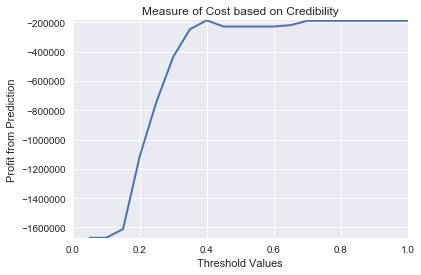


Shape of good customers data :-  (200, 21)
Shape of bad customers data :-   (300, 21)


Best: 0.732500 using {'svc_clf__C': 0.01}

Accuracy score is : 0.66

threshold value 0.05
Total Loss incurred by the Bank  -1026000.0 DM
threshold value 0.1
Total Loss incurred by the Bank  -846000.0 DM
threshold value 0.15000000000000002
Total Loss incurred by the Bank  -687000.0 DM
threshold value 0.2
Total Loss incurred by the Bank  -579000.0 DM
threshold value 0.25
Total Loss incurred by the Bank  -450000.0 DM
threshold value 0.3
Total Loss incurred by the Bank  -384000.0 DM
threshold value 0.35
Total Loss incurred by the Bank  -318000.0 DM
threshold value 0.39999999999999997
Total Loss incurred by the Bank  -213000.0 DM
threshold value 0.44999999999999996
Total Loss incurred by the Bank  -309000.0 DM
threshold value 0.49999999999999994
Total Loss incurred by the Bank  -291000.0 DM
threshold value 0.5499999999999999
Total Loss incurred by the Bank  -273000.0 DM
threshold value 0.6
Total Loss in

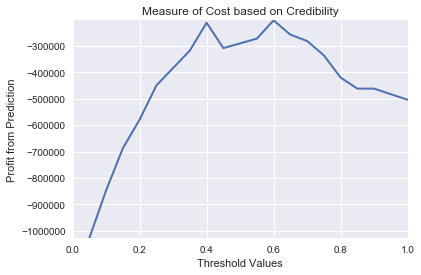


Shape of good customers data :-  (300, 21)
Shape of bad customers data :-   (300, 21)


Best: 0.731250 using {'svc_clf__C': 0.001}

Accuracy score is : 0.725

threshold value 0.05
Total Loss incurred by the Bank  -1221000.0 DM
threshold value 0.1
Total Loss incurred by the Bank  -1131000.0 DM
threshold value 0.15000000000000002
Total Loss incurred by the Bank  -1005000.0 DM
threshold value 0.2
Total Loss incurred by the Bank  -846000.0 DM
threshold value 0.25
Total Loss incurred by the Bank  -810000.0 DM
threshold value 0.3
Total Loss incurred by the Bank  -681000.0 DM
threshold value 0.35
Total Loss incurred by the Bank  -582000.0 DM
threshold value 0.39999999999999997
Total Loss incurred by the Bank  -402000.0 DM
threshold value 0.44999999999999996
Total Loss incurred by the Bank  -216000.0 DM
threshold value 0.49999999999999994
Total Loss incurred by the Bank  -258000.0 DM
threshold value 0.5499999999999999
Total Loss incurred by the Bank  -201000.0 DM
threshold value 0.6
Total Los

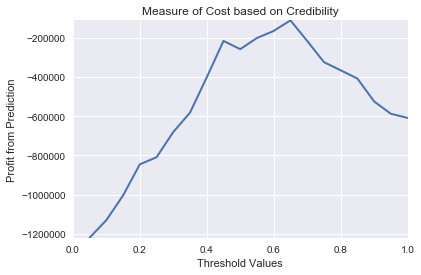


Shape of good customers data :-  (400, 21)
Shape of bad customers data :-   (300, 21)




In [ ]:
# Undersampling Good Customer Instances to have 1:1 ratio between Good and Bad Customers data
sample_good = [100,200,300,400,500,600,700]
for size in sample_good:
    good_data = good_customers.sample(n=size,random_state=42)
    print("==========================================================================================================") 
    print("")
    print("Shape of good customers data :- ",good_data.shape)
    print("Shape of bad customers data :-  ",bad_customers.shape)
    sample_data = pd.concat([bad_customers,good_data])
    sample_data,target = binary_transformation(sample_data)
    print("")  
# Split the data between Training and Test
    X_train,X_test,y_train,y_test = train_test_split(sample_data,target,test_size=0.20,random_state=42)
    print("")
# fine tune hyperparameters for linear Svc
    best_param = FineTune_SVC(X_train,y_train)
    
# Get the Confusion Matrix for Performance Metrics
    good_proba= test_evaluation(X_train,X_test,y_train,y_test,best_param['svc_clf__C'])
    thresh_cost_function(good_proba)
    print("==========================================================================================================")
    

In [ ]:
# call the function to plot thr ROC curve
    plot_roc_curve(y_test,y_scores)
    plt.show()
    print("")
    cost_function(Confusion_Matrix)
    print("")

In [ ]:
* Linear SVC model is performing better than other models with an Accuracy of .755 when the hyperparameter C is 0.01 and the raito between good and bad customers is 7:3.The cost function generates more profit margin by having better recall for good customers than Bad customers thereby increasing the net revenue of the banks.